![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

### Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Revisión de registros duplicado
dataTraining.duplicated().sum()

169

In [6]:
# Eliminación de registros duplicado
dataTraining.drop_duplicates(inplace=True)

In [7]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [8]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [9]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033


## Preprocesamiento y revisión de la data

In [30]:
# Revisión de datos Nan en todas la columnas
print(dataTraining.isna().sum())

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64


No se encuentran datos faltantes

Se verifica que las mismas categorías que están en el set de entrenamiento y testeo. En caso de que se encuentren solo en el de testeo se procede a liminarlas para mejorar el desempeño de la predicción:

In [31]:
# Obtenemos todas las categorías únicas de la columna  del conjunto de entrenamiento
train_categories = set(dataTraining['Make'].unique())

# Obtenemos todas las categorías únicas de la columna del conjunto de prueba
test_categories = set(dataTesting['Make'].unique())

# Comparamos si todas las categorías del conjunto de entrenamiento están presentes en el conjunto de prueba
if train_categories <= test_categories:
    print("Todas las categorías del conjunto de entrenamiento están presentes en el conjunto de prueba")
else:
    # Obtenemos las categorías que están en el conjunto de entrenamiento pero no en el conjunto de prueba
    missing_categories = train_categories - test_categories
    print("Las siguientes categorías del conjunto de entrenamiento no están presentes en el conjunto de prueba:")
    print(missing_categories)

Todas las categorías del conjunto de entrenamiento están presentes en el conjunto de prueba


In [32]:
# Obtenemos todas las categorías únicas de la columna del conjunto de entrenamiento
train_categories = set(dataTraining['Make'].unique())

# Obtenemos todas las categorías únicas de la columna del conjunto de prueba
test_categories = set(dataTesting['Make'].unique())

# Comparamos si todas las categorías del conjunto de prueba están presentes en el conjunto de entrenamiento
if test_categories <= train_categories:
    print("Todas las categorías del conjunto de prueba están presentes en el conjunto de entrenamiento")
else:
    # Obtenemos las categorías que están en el conjunto de prueba pero no en el conjunto de entrenamiento
    missing_categories = test_categories - train_categories
    print("Las siguientes categorías del conjunto de prueba no están presentes en el conjunto de entrenamiento:")
    print(missing_categories)

Todas las categorías del conjunto de prueba están presentes en el conjunto de entrenamiento


Se realiza el barrido por las columnas State, Make y Model. Se identifica que solo en la columna Make se encuentra una categoria que no está en el de testeo y se llama "Freightliner", por ello se procede a borrarla.

In [33]:
dataTraining = dataTraining.loc[dataTraining['Make'] != 'Freightliner']

In [34]:
# Revisando las dimensiones de los set de datos
print("las dimensiones del set de entrenamiento son: ",dataTraining.shape)
print("las dimensiones del set de testeo son: ",dataTesting.shape)

las dimensiones del set de entrenamiento son:  (399824, 6)
las dimensiones del set de testeo son:  (100000, 5)


In [35]:
# Tipo de datos
dataTraining.dtypes

Price       int64
Year        int64
Mileage     int64
State      object
Make       object
Model      object
dtype: object

Se tienen 3 variables numéricas y 3 categóricas

In [36]:
# Revisión de clases en la variable State
dataTraining.State.value_counts()

 TX    45914
 CA    36512
 FL    33712
 GA    18180
 NC    17928
 IL    16788
 VA    15893
 PA    13034
 NY    12445
 NJ    12129
 OH    11364
 WA    10898
 CO    10870
 AZ    10747
 TN     9273
 MA     8586
 MD     8243
 MO     8029
 IN     7849
 KY     6688
 AL     6282
 WI     5612
 MN     5414
 MI     5326
 OK     5096
 CT     4942
 OR     4907
 SC     4814
 UT     4795
 LA     3847
 KS     3704
 NV     3332
 AR     3125
 MS     3043
 NH     2744
 NE     2522
 IA     2325
 NM     2280
 ID     1736
 DE     1221
 HI     1180
 MT      997
 ME      965
 RI      833
 AK      813
 ND      681
 WV      666
 SD      620
 VT      579
 WY      335
 DC        6
Name: State, dtype: int64

In [37]:
dataTraining.State.unique()

array([' FL', ' OH', ' TX', ' CO', ' ME', ' WA', ' CT', ' CA', ' LA',
       ' NY', ' PA', ' SC', ' ND', ' NC', ' GA', ' AZ', ' TN', ' KY',
       ' NJ', ' UT', ' IA', ' AL', ' NE', ' IL', ' OK', ' MD', ' NV',
       ' WV', ' MI', ' VA', ' WI', ' MA', ' OR', ' IN', ' NM', ' MO',
       ' HI', ' KS', ' AR', ' MN', ' MS', ' MT', ' AK', ' VT', ' SD',
       ' NH', ' DE', ' ID', ' RI', ' WY', ' DC'], dtype=object)

In [38]:
# Revisión de clases en la variable Make
dataTraining.Make.value_counts()

Ford             62837
Chevrolet        58354
Toyota           45903
Honda            33188
Jeep             24366
GMC              20834
Kia              16341
Dodge            16158
Hyundai          15054
Lexus            13663
BMW              12326
Volkswagen       11110
Nissan           10569
Chrysler          9045
Mercedes-Benz     7570
Subaru            6791
Cadillac          5414
Buick             4841
Ram               3607
MINI              2766
Land              2711
INFINITI          2406
Acura             2399
Mazda             2332
Lincoln           1786
Volvo             1710
Audi              1423
Mitsubishi        1271
Porsche            980
Scion              651
Jaguar             324
Pontiac            308
FIAT               272
Mercury            271
Tesla              148
Bentley             57
Suzuki              38
Name: Make, dtype: int64

In [39]:
dataTraining.Make.unique()

array(['Jeep', 'Chevrolet', 'BMW', 'Cadillac', 'Mercedes-Benz', 'Toyota',
       'Buick', 'Dodge', 'Volkswagen', 'GMC', 'Ford', 'Hyundai',
       'Mitsubishi', 'Honda', 'Nissan', 'Mazda', 'Volvo', 'Kia', 'Subaru',
       'Chrysler', 'INFINITI', 'Land', 'Porsche', 'Lexus', 'MINI',
       'Lincoln', 'Audi', 'Ram', 'Mercury', 'Tesla', 'FIAT', 'Acura',
       'Scion', 'Pontiac', 'Jaguar', 'Bentley', 'Suzuki'], dtype=object)

In [40]:
# Revisión de clases en la variable Model
dataTraining.Model.value_counts()

Silverado          18077
Grand              12343
Sierra              8409
Accord              7357
F-1504WD            6684
                   ...  
PathfinderSE          53
Galant4dr             53
SLK-ClassSLK350       52
Monte                 48
RX-84dr               48
Name: Model, Length: 525, dtype: int64

In [41]:
dataTraining.Model.unique()

array(['Wrangler', 'Tahoe4WD', 'X5AWD', 'SRXLuxury', '3', 'C-ClassC300',
       'CamryL', 'TacomaPreRunner', 'LaCrosse4dr', 'ChargerSXT',
       'CamryLE', 'Jetta', 'AcadiaFWD', 'EscapeSE', 'SonataLimited',
       'Santa', 'Outlander', 'CruzeSedan', 'Civic', 'CorollaL', '350Z2dr',
       'EdgeSEL', 'F-1502WD', 'FocusSE', 'PatriotSport', 'Accord',
       'MustangGT', 'FusionHybrid', 'ColoradoCrew', 'Wrangler4WD',
       'CR-VEX-L', 'CTS', 'CherokeeLimited', 'Yukon', 'Elantra', 'New',
       'CorollaLE', 'Canyon4WD', 'Golf', 'Sonata4dr', 'Elantra4dr',
       'PatriotLatitude', 'Mazda35dr', 'Tacoma2WD', 'Corolla4dr',
       'Silverado', 'TerrainFWD', 'EscapeFWD', 'Grand', 'RAV4FWD',
       'Liberty4WD', 'FocusTitanium', 'DurangoAWD', 'S60T5', 'CivicLX',
       'MuranoAWD', 'ForteEX', 'TraverseAWD', 'CamaroConvertible',
       'Sportage2WD', 'Pathfinder4WD', 'Highlander4dr', 'WRXSTI', 'Ram',
       'F-150XLT', 'SiennaXLE', 'LaCrosseFWD', 'RogueFWD', 'CamaroCoupe',
       'JourneySXT', 'Acc

In [42]:
dataTraining.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,399824.0,NaN,NaN,NaN,21143.909858,10751.995781,5001.0,13499.0,18449.0,26999.0,79999.0
Year,399824.0,NaN,NaN,NaN,2013.196574,3.292087,1997.0,2012.0,2014.0,2016.0,2018.0
Mileage,399824.0,NaN,NaN,NaN,55093.119805,40876.008607,5.0,25864.75,42970.0,77454.25,2457832.0
State,399824,51,TX,45914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Make,399824,37,Ford,62837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,399824,525,Silverado,18077,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como se evidencian muchas clases para cada variable categórica (State, Make y Model), se procede a codificarlas con números. En especial la variable Model presenta 525 modelos de carros diferentes.

In [43]:
# Importar librerías necesarias
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Crear copias de los conjuntos de datos originales
dataTraining_copy = dataTraining.copy()
dataTesting_copy = dataTesting.copy()

# Crear objetos transformadores
le_state = LabelEncoder()
le_make = LabelEncoder()
le_model = LabelEncoder()

# Ajustar transformadores en datos combinados
le_state.fit(dataTraining_copy['State'])
le_make.fit(dataTraining_copy['Make'])
le_model.fit(dataTraining_copy['Model'])

# Transformar variables categóricas en variables numéricas
dataTraining_copy['State_cod'] = le_state.transform(dataTraining_copy['State'])
dataTraining_copy['Make_cod'] = le_make.transform(dataTraining_copy['Make'])
dataTraining_copy['Model_cod'] = le_model.transform(dataTraining_copy['Model'])

# Eliminar variables categóricas originales
#dataTraining_copy.drop(['State', 'Make', 'Model'], axis=1, inplace=True)

# Transformar variables categóricas en variables numéricas en el conjunto de prueba
dataTesting_copy['State_cod'] = le_state.transform(dataTesting_copy['State'])
dataTesting_copy['Make_cod'] = le_make.transform(dataTesting_copy['Make'])
dataTesting_copy['Model_cod'] = le_model.transform(dataTesting_copy['Model'])

# Eliminar variables categóricas originales del conjunto de prueba
dataTesting_copy.drop(['State', 'Make', 'Model'], axis=1, inplace=True)

In [44]:
dataTraining_copy

,Price,Year,Mileage,State,Make,Model,State_cod,Make_cod,Model_cod
0,34995,2017,9913,FL,Jeep,Wrangler,9,16,489
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD,35,6,448
2,18430,2012,83716,TX,BMW,X5AWD,43,2,499
3,24681,2014,28729,OH,Cadillac,SRXLuxury,35,5,398
4,26998,2013,64032,CO,Jeep,Wrangler,5,16,489
...,...,...,...,...,...,...,...,...,...
399995,29900,2015,25287,TX,Lexus,RXRX,43,19,377
399996,17688,2015,17677,MI,Chevrolet,EquinoxFWD,22,6,158
399997,24907,2014,66688,NC,Buick,EnclaveLeather,27,4,154
399998,11498,2014,37872,IN,Volkswagen,Jetta,15,35,264


In [45]:
# Se crean los diccionarios que se emplearán para el API
diccionario_state= dict(zip(dataTraining_copy['State'], dataTraining_copy['State_cod']))
diccionario_Make = dict(zip(dataTraining_copy['Make'], dataTraining_copy['Make_cod']))
diccionario_Model = dict(zip(dataTraining_copy['Model'], dataTraining_copy['Model_cod']))

# Eliminar variables categóricas originales
dataTraining_copy.drop(['State', 'Make', 'Model'], axis=1, inplace=True)
dataTraining_copy.head(5)

,Price,Year,Mileage,State_cod,Make_cod,Model_cod
0,34995,2017,9913,9,16,489
1,37895,2015,20578,35,6,448
2,18430,2012,83716,43,2,499
3,24681,2014,28729,35,5,398
4,26998,2013,64032,5,16,489


In [46]:
diccionario_Model.get('Wrangler')

489

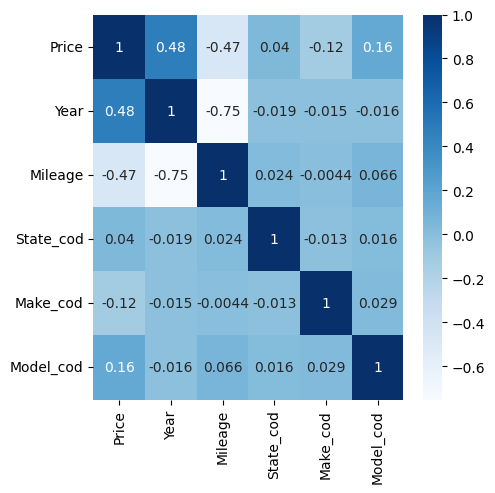

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
# Se realiza la matriz de correlación
corr = dataTraining_copy.corr(method='pearson')
plt.figure(figsize=(5,5))
sns.heatmap(corr, cmap='Blues', annot=True)
plt.show()

Se observa una correlación postiva entre el precio y el año, puesto que a medida que el carro sea un año mayor estaría más nuevo y por eso incrementa su valor. También se observa correlación negativa entre el kilometraje y el precio (-0.47) lo cual es de esperarse puesto que a mayor número de distancia recorrida por el vehículo, su valor disminuye considerablemente.

Ahora, para poder proceder al entrenamiento de los modelos se realiza la división del set de entrenamiento en Train y Test para evaluar el desempeño.

In [48]:
from sklearn.model_selection import train_test_split

y = dataTraining_copy['Price']
X = dataTraining_copy.drop(['Price'], axis=1)

# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Selección de los modelos iniciales

Se plantea modelar un Random Forest y un modelo XGBoost para predecir el precio del vehículo. A partir de los resultados obtenido para sus métricas de desempeño, se procede a optimizar los hiperparámetros del modelo escogido.

## Random Forest Regressor - Sin optimizar

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Se crea la instancia del modelo RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=123)

# Se ajusta el modelo con los datos de entrenamiento 
rf_reg.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento y testeo
y_pred_train_rf = rf_reg.predict(X_train)
y_pred_test_rf = rf_reg.predict(X_test)

# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print('\nResultados en conjunto de train:')
print("MSE:", mse_train_rf)
print("RMSE:", rmse_train_rf)
print("MAE:", mae_train_rf)
print("r2 score:", r2_train_rf)

print('\nResultados en conjunto de test:')
print("MSE:", mse_test_rf)
print("RMSE:", rmse_test_rf)
print("MAE:", mae_test_rf)
print("r2 score:", r2_test_rf)


Resultados en conjunto de train:
MSE: 2012935.052033494
RMSE: 1418.7794233190352
MAE: 878.7215925965083
r2 score: 0.9826147109164927

Resultados en conjunto de test:
MSE: 14029755.973425226
RMSE: 3745.6315853838623
MAE: 2356.9656582235484
r2 score: 0.8778837492517106


Se revisa la importancia de las variables según este modelo

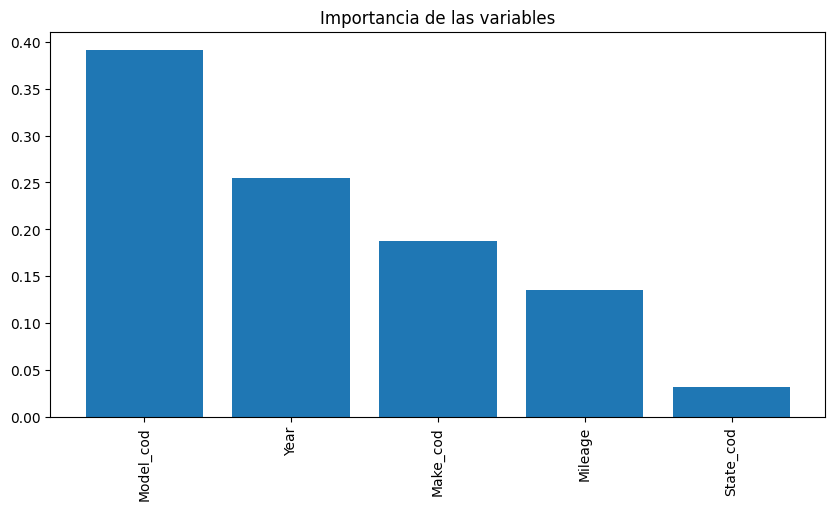

In [50]:
import matplotlib.pyplot as plt
# Obtener la importancia de las variables
importances = rf_reg.feature_importances_

# Ordenar las importancias de mayor a menor
sorted_idx = importances.argsort()[::-1]

# Obtener el nombre de las variables
feature_names = X_train.columns

# Mostrar las importancias de las variables en un gráfico de barras
plt.figure(figsize=(10, 5))
plt.title("Importancia de las variables")
plt.bar(range(X_train.shape[1]), importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), feature_names[sorted_idx], rotation=90)
plt.show()

## XGBoost - Sin optimizar

In [51]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error

# Se crea la instancia del modelo XGBRegressor
xgb_reg = xgb.XGBRegressor(seed=42)

# Se ajusta el modelo con los datos de entrenamiento 
xgb_reg.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento y testeo
y_pred_train_xgb = xgb_reg.predict(X_train)
y_pred_test_xgb = xgb_reg.predict(X_test)

# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mse_train_xgb)
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

# Calcular el MSE, RMSE, MAE y r2 para el set de prueba
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mse_test_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

# Imprimir los resultados
print('\nResultados en conjunto de train:')
print("MSE:", mse_train_xgb)
print("RMSE:", rmse_train_xgb)
print("MAE:", mae_train_xgb)
print("r2 score:", r2_train_xgb)

print('\nResultados en conjunto de test:')
print("MSE:", mse_test_xgb)
print("RMSE:", rmse_test_xgb)
print("MAE:", mae_test_xgb)
print("r2 score:", r2_test_xgb)


Resultados en conjunto de train:
MSE: 12885698.413784523
RMSE: 3589.6655016567383
MAE: 2369.82630622413
r2 score: 0.8887089815738336

Resultados en conjunto de test:
MSE: 13351433.566076038
RMSE: 3653.961352570117
MAE: 2413.2563399575884
r2 score: 0.8837879281512538


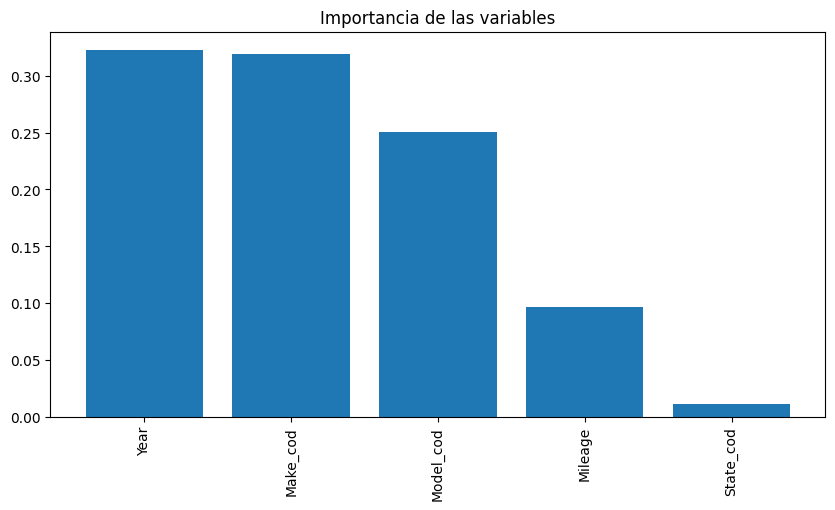

In [52]:
# Obtener la importancia de las variables
importances = xgb_reg.feature_importances_

# Ordenar las importancias de mayor a menor
sorted_idx = importances.argsort()[::-1]

# Obtener el nombre de las variables
feature_names = X_train.columns

# Mostrar las importancias de las variables en un gráfico de barras
plt.figure(figsize=(10, 5))
plt.title("Importancia de las variables")
plt.bar(range(X_train.shape[1]), importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), feature_names[sorted_idx], rotation=90)
plt.show()

Evaluando los dos modelos se evidencian las siguientes métricas de desempeño en el 20% de los datos que se destinaron para testeo:


Modelo                              | MSE      | RMSE     | MAE    |R2_score|
------------------------------------|----------|----------|--------|--------|
 Random Forest Sin optimizar        |14029755  | 3745.63  |2356.96 |0.8766  |
 XGBoost -  Sin optimizar           |13351433  | 3653.96  |2413.25 |0.8837  |


En las métricas de entrenamiento el Random Forest muestra mejor desempeño, lo cual indica que se puede estar sobreajustando. Por el desempeño obtenido, se procede a optimizar el modelo de XGBoost. 


## Calibración del modelo 

XGBoost - Optimizado parámetro a parámetro

In [53]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV,cross_val_score

Text(0, 0.5, 'RMSE en Train')

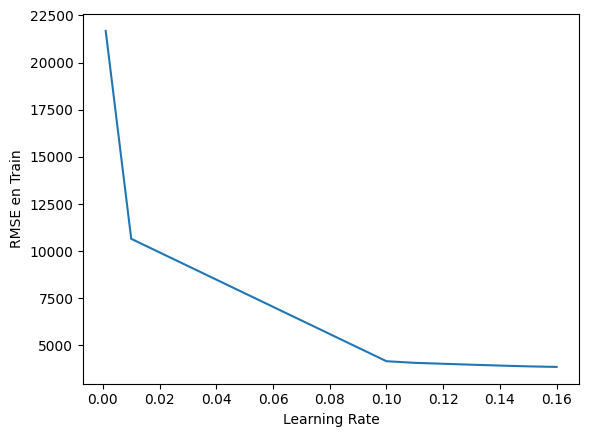

In [54]:
###################################################   Definición de learning_rate ##########################################################

# Definición de una lista de valores para iterar sobre diferentes valores de learning_rate
lr_range = [0.001, 0.01, 0.1, 0.11, 0.12,0.13,0.14,0.15,0.16]

# Definición de una lista para almacenar el RMSE promedio para cada valor de learning_rate
rmse_scores = []

# Uso de validación cruzada para cada valor de learning_rate
for lr in lr_range:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=lr, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(xg_reg, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs learning_rate
plt.plot(lr_range, rmse_scores)
plt.xlabel('Learning Rate')
plt.ylabel('RMSE en Train')

learning_rate: es la tasa de aprendizaje que controla la contribución de cada árbol a la predicción. Un valor más alto significa que el modelo aprende más rápido, pero también puede llevar a un sobreajuste. En este caso, se ha definido una tasa de aprendizaje de 0.16 en donde el RMSE no presenta una variación considerable.

Text(0, 0.5, 'RMSE en Train')

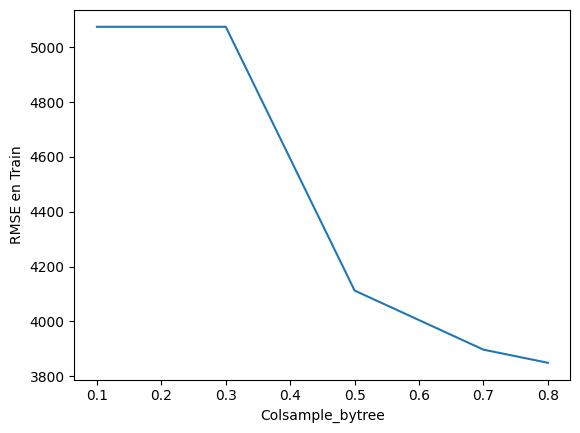

In [ ]:
###################################################   Definición de colsample_bytree ##########################################################

# Definición de una lista de valores para iterar sobre diferentes valores de colsample_bytree
col_range = [0.1, 0.3, 0.5, 0.7, 0.8]

# Definición de una lista para almacenar el RMSE promedio para cada valor de colsample_bytree
rmse_scores = []

# Uso de validación cruzada para cada valor de colsample_bytree
for col in col_range:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=col, learning_rate=0.16, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(xg_reg, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs colsample_bytree
plt.plot(col_range, rmse_scores)
plt.xlabel('Colsample_bytree')
plt.ylabel('RMSE en Train')


colsample_bytree: se refiere a la proporción de columnas de características (variables) que se utilizan en cada árbol. En este caso, se está usando el 80% de las columnas de características en donde el RMSE no presenta una variación considerable.

Text(0, 0.5, 'RMSE en Train')

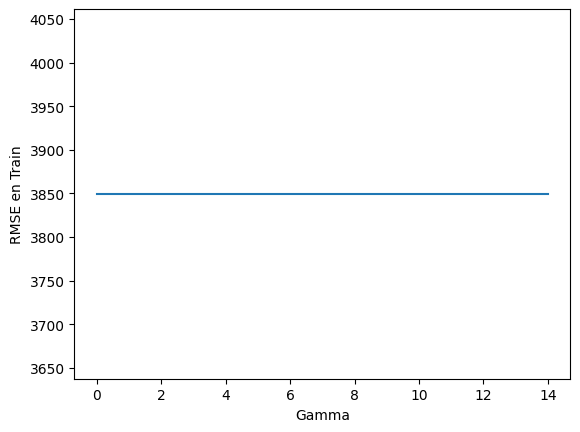

In [ ]:
###################################################   Definición de gamma ##########################################################

# Definición de una lista de valores para iterar sobre diferentes valores de gamma
gamma_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Definición de una lista para almacenar el RMSE promedio para cada valor de gamma
rmse_scores = []

# Uso de validación cruzada para cada valor de gamma
for gamma in gamma_range:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', gamma=gamma,learning_rate=0.16, colsample_bytree=0.80,  random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(xg_reg,X, y, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs gamma
plt.plot(gamma_range, rmse_scores)
plt.xlabel('Gamma')
plt.ylabel('RMSE en Train')


Gamma = 0
gamma: es un parámetro que controla la cantidad de reducción de pérdida necesaria para realizar una partición adicional en un nodo durante el proceso de creación de árboles. Un valor más alto de gamma puede llevar a un modelo más simple y reducir el sobreajuste. EN este caso, se ha definido un gamma de cero, ya que el RMSE no presenta mejora cuando este parámetro cambia 

Text(0, 0.5, 'RMSE en Train')

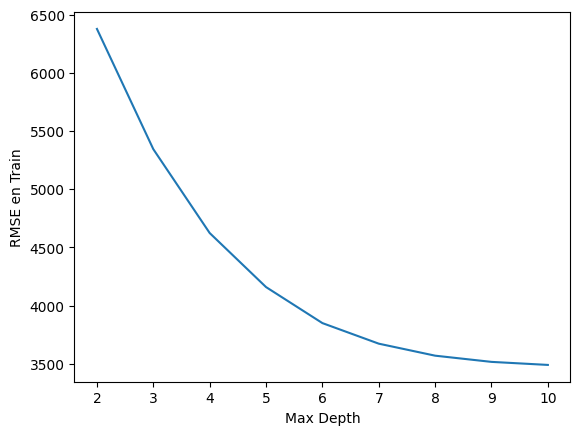

In [ ]:
# Definición de una lista de valores para iterar sobre diferentes valores de max_depth
max_depth_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Definición de una lista para almacenar el RMSE promedio para cada valor de max_depth
rmse_scores = []

# Uso de validación cruzada para cada valor de max_depth
for max_depth in max_depth_range:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=max_depth,  gamma=0, learning_rate=0.16, colsample_bytree=0.80, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(xg_reg, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs max_depth
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('Max Depth')
plt.ylabel('RMSE en Train')

max_depth: define la profundidad máxima de cada árbol en el modelo. Un valor más alto puede llevar a un sobreajuste, mientras que un valor más bajo puede llevar a un subajuste. En este caso, se ha definido una profundidad máxima de 10 ya que hasta ahí se consigue un RMSE más bajo para los valores analizados.

Text(0, 0.5, 'RMSE en Train')

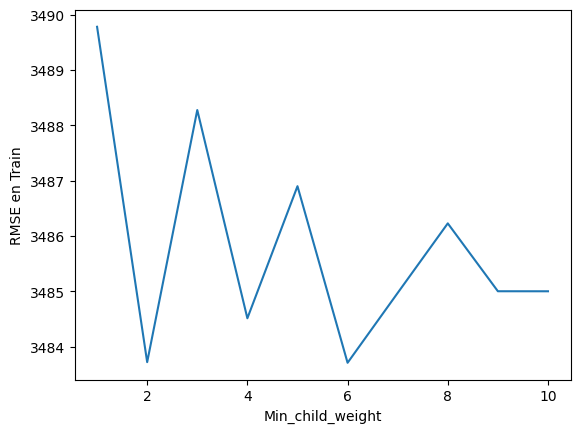

In [ ]:
# Definición de una lista de valores para iterar sobre diferentes valores de min_child_weight
min_child_weight_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Definición de una lista para almacenar el RMSE promedio para cada valor de min_child_weight
rmse_scores = []

# Uso de validación cruzada para cada valor de min_child_weight
for min_child_weight in min_child_weight_range:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=min_child_weight,  max_depth=10,  gamma=0, learning_rate=0.16, colsample_bytree=0.80, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(xg_reg, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs min_child_weight
plt.plot(min_child_weight_range, rmse_scores)
plt.xlabel('Min_child_weight')
plt.ylabel('RMSE en Train')

min_child_weight: define la cantidad mínima de muestras necesarias en cada hoja de un árbol. Un valor más alto puede evitar el sobreajuste, mientras que un valor más bajo puede llevar a un sobreajuste. En este caso, se ha definido una cantidad mínima de muestras de 2 ya que según la gráfica muestra un mínimo global de los valores evaluados para el RMSE.

In [ ]:
# Definición de una lista de valores para iterar sobre diferentes valores de n_estimators
n_estimators_range = range(10, 310, 10)

# Definición de una lista para almacenar el RMSE promedio para cada valor de n_estimators
rmse_scores = []

# Uso de validación cruzada para cada valor de n_estimators
for n in n_estimators_range:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n, min_child_weight=2,  max_depth=10,  gamma=0, learning_rate=0.16, colsample_bytree=0.80, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(xg_reg, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs n_estimators
plt.plot(n_estimators_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE en Train')

n_estimators: es el número total de árboles que se utilizan en el modelo. Un valor más alto puede mejorar el rendimiento del modelo, pero también aumenta el tiempo de entrenamiento. En este caso, se han definido 300 árboles porque es cuando se estabilizan los valores de RMSE.

Text(0, 0.5, 'RMSE en Train')

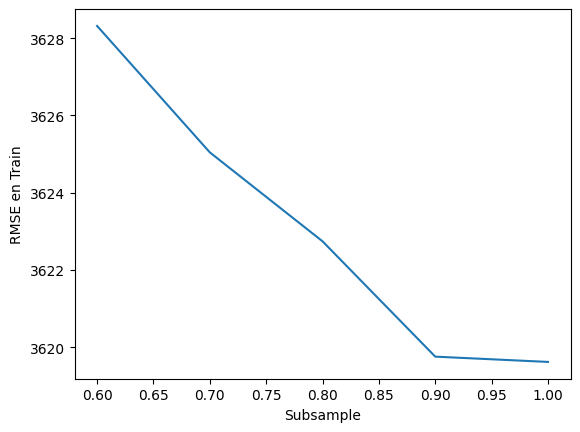

In [ ]:
# Definición de una lista de valores para iterar sobre diferentes valores de subsample
subsample_range = [0.6, 0.7, 0.8, 0.9, 1.0]

# Definición de una lista para almacenar el RMSE promedio para cada valor de subsample
rmse_scores = []

# Uso de validación cruzada para cada valor de subsample
for subsample in subsample_range:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample=subsample, n_estimators=275, learning_rate=0.125, colsample_bytree=0.70, min_child_weight=1, gamma=0, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(xg_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs subsample
plt.plot(subsample_range, rmse_scores)
plt.xlabel('Subsample')
plt.ylabel('RMSE en Train')


subsample: se refiere a la proporción de muestras de entrenamiento que se utilizan para cada árbol. Un valor más bajo puede llevar a un modelo más simple, pero también puede aumentar el sobreajuste. En este caso se define en 0.9 porque a partir de allí se estabiliza el cambio en el RMSE.

## Entrenamiento del modelo Optimizado

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error

# Esta es la mejor combinación
xgb_reg_f = xgb.XGBRegressor(colsample_bytree=0.8,
                             gamma=0,
                             seed=42,
                             learning_rate=0.16,
                             max_depth=10,
                             min_child_weight=2,
                             n_estimators=300,
                             subsample=1,
                             n_jobs=1)


# Entrenar el modelo
xgb_reg_f.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento y testeo
y_pred_train_xgb_f = xgb_reg_f.predict(X_train)
y_pred_test_xgb_f = xgb_reg_f.predict(X_test)

# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train_xgb_f = mean_squared_error(y_train, y_pred_train_xgb_f)
rmse_train_xgb_f = np.sqrt(mse_train_xgb_f)
mae_train_xgb_f = mean_absolute_error(y_train, y_pred_train_xgb_f)
r2_train_xgb_f = r2_score(y_train, y_pred_train_xgb_f)

# Calcular el MSE, RMSE, MAE y r2 para el set de prueba
mse_test_xgb_f = mean_squared_error(y_test, y_pred_test_xgb_f)
rmse_test_xgb_f = np.sqrt(mse_test_xgb_f)
mae_test_xgb_f = mean_absolute_error(y_test, y_pred_test_xgb_f)
r2_test_xgb_f = r2_score(y_test, y_pred_test_xgb_f)

# Imprimir los resultados
print('\nResultados en conjunto de train:')
print("MSE:", mse_train_xgb_f)
print("RMSE:", rmse_train_xgb_f)
print("MAE:", mae_train_xgb_f)
print("r2 score:", r2_train_xgb_f)

print('\nResultados en conjunto de test:')
print("MSE:", mse_test_xgb_f)
print("RMSE:", rmse_test_xgb_f)
print("MAE:", mae_test_xgb_f)
print("r2 score:", r2_test_xgb_f)


Resultados en conjunto de train:
MSE: 8644697.534081625
RMSE: 2940.1866495312206
MAE: 1874.957099238026
r2 score: 0.9253375981914238

Resultados en conjunto de test:
MSE: 11827235.908052085
RMSE: 3439.0748622343312
MAE: 2184.081409168452
r2 score: 0.8970546808837867


Como se evidencia, el hecho de optimizar los hiperparámetros permite mejorar el rendimiento del modelo como se evidencia en esta tabla resumen:

Modelo                              | MSE      | RMSE     | MAE    |R2_score|
------------------------------------|----------|----------|--------|--------|
 Random Forest Sin optimizar        |14029755  | 3745.63  |2356.96 |0.8766  |
 XGBoost -  Sin optimizar           |13351433  | 3653.96  |2413.25 |0.8837  |
 XGBoost -  Optimizado              |11827235  | 3439.07  |2184.08 |0.8970  |

Por esta razón se escoge el modelo XGBoost con los hiperparámetros optimizados para modelar el problema. Acontinuación se grafican nuevamente la importancia de las variables para este modelo:

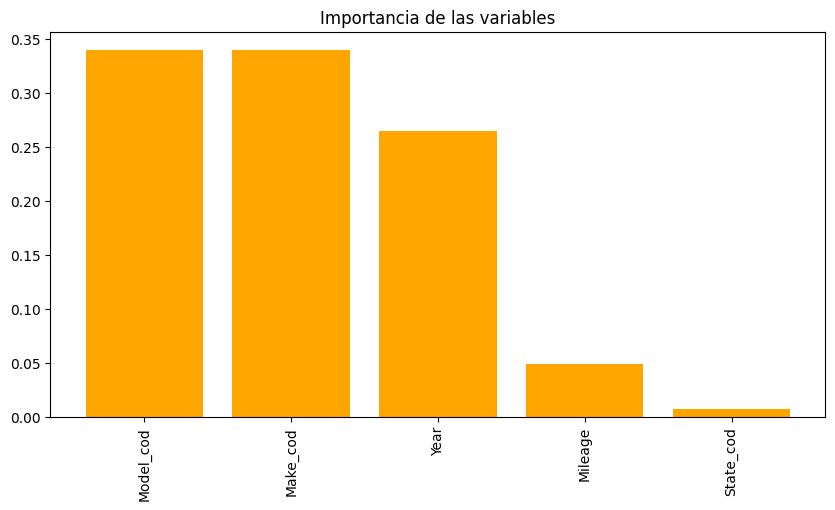

In [ ]:
# Obtener la importancia de las variables
importances = xgb_reg_f.feature_importances_

# Ordenar las importancias de mayor a menor
sorted_idx = importances.argsort()[::-1]

# Obtener el nombre de las variables
feature_names = X_train.columns

# Mostrar las importancias de las variables en un gráfico de barras naranja
plt.figure(figsize=(10, 5))
plt.title("Importancia de las variables")
plt.bar(range(X_train.shape[1]), importances[sorted_idx], color='orange')
plt.xticks(range(X_train.shape[1]), feature_names[sorted_idx], rotation=90)
plt.show()


## Re-entrenamiento del modelo con todos los datos

Para ser subidos a la competencia de Kaggle

In [ ]:
# Esta es la mejor combinación
xgb_reg_f = xgb.XGBRegressor(colsample_bytree=0.8,
                             gamma=0,
                             seed=42,
                             learning_rate=0.16,
                             max_depth=10,
                             min_child_weight=2,
                             n_estimators=300,
                             subsample=1,
                             n_jobs=1)


# Entrenar el modelo
xgb_reg_f.fit(X, y)

# Realizar predicciones con los datos de entrenamiento
y_pred_train_xgb_f = xgb_reg_f.predict(X)


# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train_xgb_f = mean_squared_error(y, y_pred_train_xgb_f)
rmse_train_xgb_f = np.sqrt(mse_train_xgb_f)
mae_train_xgb_f = mean_absolute_error(y, y_pred_train_xgb_f)
r2_train_xgb_f = r2_score(y, y_pred_train_xgb_f)

# Imprimir los resultados
print('\nResultados en conjunto de train:')
print("MSE:", mse_train_xgb_f)
print("RMSE:", rmse_train_xgb_f)
print("MAE:", mae_train_xgb_f)
print("r2 score:", r2_train_xgb_f)


Resultados en conjunto de train:
MSE: 8979381.066741789
RMSE: 2996.5615406231504
MAE: 1910.2298269908197
r2 score: 0.9223265424221095


## Arreglando el set de datos para la competencia

In [ ]:
y_pred_test_xgb_f = xgb_reg_f.predict(dataTesting_copy)
y_pred_test_xgb_f

array([21223.596, 36735.914, 23608.584, ..., 24322.777, 17007.18 ,
       20647.756], dtype=float32)

In [ ]:
df_prueba = pd.DataFrame(y_pred_test_xgb_f)
df_prueba.reset_index(inplace=True)
df_prueba['ID']=df_prueba['index']
df_prueba = df_prueba.drop(['index'], axis=1)
df_prueba = df_prueba.rename(columns={ 0:'Price'})
df_prueba = df_prueba.set_index('ID', drop=True)
df_prueba

,Price
ID,
0,21223.595703
1,36735.914062
2,23608.583984
3,7176.071289
4,30843.378906
...,...
99995,24336.476562
99996,37977.535156
99997,24322.777344


In [ ]:
# Conexión a Google Colab
from google.colab import drive
drive.mount('/content/drive/')
# Se le define la ruta de los archivos en el Drive
%cd '/content/drive/My Drive/MIAD_ML_&_PNL/3 Semana/'
# Se listan los archivos en Drive
!ls

Mounted at /content/drive/
/content/drive/My Drive/MIAD_ML_&_PNL/3 Semana
'Copia de S3P1_proyecto1.ipynb'   test_submission_2.csv
 S3P1_proyecto1_Entrega.ipynb	  test_submission_3.csv
 S3P1_proyecto1.ipynb		  test_submission_4_xgb_f.csv
 test_submission_1.csv		  test_submission.csv


In [ ]:
#y_pred.to_csv('test_submission.csv', index_label='ID')
df_prueba.to_csv('test_submission_5prueba_xgb_f.csv', index_label='ID', sep=',', decimal='.')